<a href="https://colab.research.google.com/github/suehuynh/mooc-network-analysis/blob/main/MOOC_User_Action_Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MOOC User Action - Network Analysis

## Abstract

Massive Open Online Courses (MOOCs) provide accessible education to learners worldwide. However, optimizing the platforms for better student engagement remains a critical challenge. This study examines student interactions within a MOOC platform, leveraging network analysis to identify activities that encourage or discourage student retention. By analyzing user-activity engagement patterns, this paper uncovers key insights into how certain activities contribute to student disengagement. The findings suggest that activities requiring repeated attempts before completion correlate with increased dropout likelihood. To elevate learning experience, smart interventions such as enhanced guidance and adaptive learning mechanisms should be considered.


## Introduction
MOOCs have transformed education by providing flexible learning opportunities. Consequently, strategies to enhance the learning experience for students on these platforms are in high demand. This study aims to answer: *What activities encourage or discourage students from studying on MOOC platforms?* By constructing and analyzing a bipartite graph of student interactions, I identify activities with high dropout risk and propose potential improvements.


## Methodology

### Describe the dataset
**Dataset Description**

The dataset consists of user interactions with various activities on a MOOC platform from SNAP Stanford (https://snap.stanford.edu/data/act-mooc.html). It is composed of three files:

mooc_actions.tsv (Tab-separated format):
* ACTIONID: Unique identifier for each action.
* USERID: Unique identifier for each user.
* TARGETID: Unique identifier for each target activity.
* TIMESTAMP: Timestamp of the action in seconds from the beginning.

mooc_action_features.tsv (Tab-separated format):
* ACTIONID: Unique identifier for each action.
* FEATURE0, FEATURE1, FEATURE2, FEATURE4: A 4-dimensional feature vector associated with the action.

mooc_action_labels.tsv (Tab-separated format):
* ACTIONID: Unique identifier for each action.
* LABEL: Binary label indicating whether the student drops out after the action (1 for dropout, 0 otherwise).

To investigate student engagement and dropout patterns, I constructed a bipartite network where users interact with various course activities. The three datasets were merged into a single data frame containing interaction records and dropout labels. By modeling this dataframe as a network, I analyzed engagement patterns and identified factors contributing to student dropout.

First, I tested whether the network's degree distributions follow a power-law distribution to guide further quantitative analysis. Next, I compared network density across dropout and non-dropout subgraphs to assess whether dropout behavior correlates with connectivity. Additionally, I computed degree centrality to evaluate whether highly influential activities contribute to disengagement. Lastly, I analyzed interaction frequency before dropout to determine if repeated failed attempts correlated with disengagement.



# Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import datetime
import time
!pip install powerlaw
import powerlaw

In [2]:
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io
import os

auth.authenticate_user()
drive_service = build('drive', 'v3')

folder_id = '19tpB5OaBXQHVFu3TZrcbg71X6NtMu2uF'

# Get a list of files in the folder
results = drive_service.files().list(
    q=f"'{folder_id}' in parents and mimeType='text/tab-separated-values'",  # Query for TSV files
    fields="nextPageToken, files(id, name)"
).execute()
items = results.get('files', [])

In [3]:
# Create a dictionary to store the DataFrames
dfs = {}

for item in items:
    print(f"Processing file: {item['name']}")

    # Download the file
    request = drive_service.files().get_media(fileId=item['id'])
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print(f"Download {int(status.progress() * 100)}%.")

    downloaded.seek(0)

    # Read into DataFrame and store in the dictionary
    try:
        df = pd.read_csv(downloaded, sep='\t')
        # Use the file name (without extension) as the key in the dictionary
        dfs[item['name'].split('.')[0]] = df
    except pd.errors.ParserError as e:
        print(f"Error reading file {item['name']}: {e}")

print(f"Loaded {len(dfs)} DataFrames.")

# Features associated with each action.
df_features = dfs['mooc_action_features']
# Binary label associated with each action, indicating whether the student drops-out after the action.
df_labels = dfs['mooc_action_labels']
# Time-ordered sequence of user actions.
df_actions = dfs['mooc_actions']

Processing file: mooc_action_features.tsv
Download 100%.
Processing file: mooc_action_labels.tsv
Download 100%.
Processing file: mooc_actions.tsv
Download 100%.
Loaded 3 DataFrames.


In [4]:
df_actions

,ACTIONID,USERID,TARGETID,TIMESTAMP
0,0,0,0,0.0
1,1,0,1,6.0
2,2,0,2,41.0
3,3,0,1,49.0
4,4,0,2,51.0
...,...,...,...,...
411744,411744,7026,8,2572041.0
411745,411745,6842,8,2572043.0
411746,411746,7026,9,2572048.0
411747,411747,6842,5,2572054.0


In [5]:
df_features

,ACTIONID,FEATURE0,FEATURE1,FEATURE2,FEATURE3
0,0,-0.319991,-0.435701,0.106784,-0.067309
1,1,-0.319991,-0.435701,0.106784,-0.067309
2,2,-0.319991,-0.435701,0.106784,-0.067309
3,3,-0.319991,-0.435701,0.106784,-0.067309
4,4,-0.319991,-0.435701,0.106784,-0.067309
...,...,...,...,...,...
411744,411744,-0.319991,-0.435701,0.106784,-0.067309
411745,411745,-0.319991,-0.435701,0.106784,-0.067309
411746,411746,-0.319991,-0.435701,0.106784,-0.067309
411747,411747,-0.319991,-0.435701,0.106784,-0.067309


In [6]:
df_labels

,ACTIONID,LABEL
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
411744,411744,0
411745,411745,0
411746,411746,0
411747,411747,0


In [7]:
df_actions_labels = df_actions.merge(df_labels, on="ACTIONID", how="left")
df_actions_labels

,ACTIONID,USERID,TARGETID,TIMESTAMP,LABEL
0,0,0,0,0.0,0.0
1,1,0,1,6.0,0.0
2,2,0,2,41.0,0.0
3,3,0,1,49.0,0.0
4,4,0,2,51.0,0.0
...,...,...,...,...,...
426860,411744,7026,8,2572041.0,0.0
426861,411745,6842,8,2572043.0,0.0
426862,411746,7026,9,2572048.0,0.0
426863,411747,6842,5,2572054.0,0.0


### Network Structure and Statistics


In [8]:
# Create a bipartite graph
B = nx.Graph()  # Undirected for bipartite visualization

# Add nodes
users = set(df_actions_labels["USERID"])
activities = set(df_actions_labels["TARGETID"])

B.add_nodes_from(users, bipartite=0)  # Layer 1: Users
B.add_nodes_from(activities, bipartite=1)  # Layer 2: Course Activities

# Add edges with dropout labels
for _, row in df_actions_labels.iterrows():
    B.add_edge(row['USERID'], row['TARGETID'], dropout=row['LABEL'])
# Separate nodes by bipartite sets
user_nodes = [node for node, data in B.nodes(data=True) if data['bipartite'] == 0]
target_nodes = [node for node, data in B.nodes(data=True) if data['bipartite'] == 1]

# pos = nx.spring_layout(B, k=0.5, seed=42)

# # Draw nodes with different colors
# nx.draw_networkx_nodes(B, pos, nodelist=user_nodes, node_color='#2C95FF', node_size=50)
# nx.draw_networkx_nodes(B, pos, nodelist=target_nodes, node_color='#2CFF96', node_size=50)

# edge_colors = ['red' if B[u][v].get('dropout', 0) == 1 else 'gray' for u, v in B.edges()]
# nx.draw_networkx_edges(B, pos, edge_color=edge_colors, alpha=0.6, width=0.8)

# # Add legend manually
# plt.scatter([], [], color='#2C95FF', label='Users')
# plt.scatter([], [], color='#2CFF96', label='Targets')
# plt.scatter([], [], color='red', label='Dropout Interaction', alpha=0.7)
# plt.scatter([], [], color='gray', label='Non-Dropout Interaction', alpha=0.7)
# plt.legend()

# plt.title("Bipartite MOOC Network: Users & Course Activities")
# plt.show()

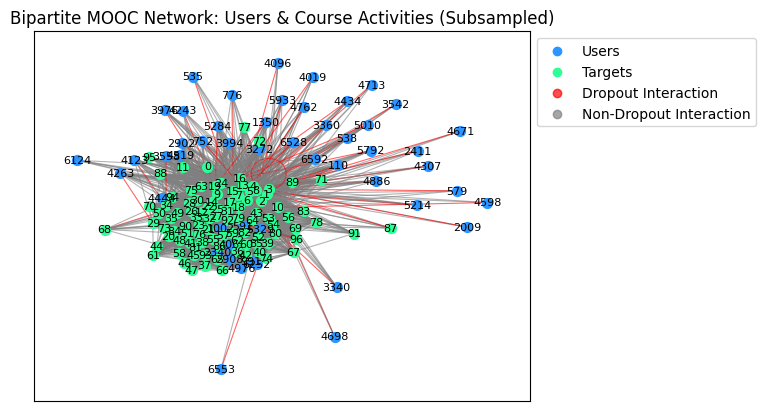

In [9]:
import random
# Randomly select 50 users
sampled_users = random.sample(user_nodes, 50)

# Create a subgraph with the sampled users and all targets
subgraph_nodes = sampled_users + target_nodes
subgraph = B.subgraph(subgraph_nodes)

# Layout
pos = nx.spring_layout(subgraph, k=0.5, seed=42)

# Draw nodes with different colors
nx.draw_networkx_nodes(subgraph, pos, nodelist=sampled_users, node_color='#2C95FF', node_size=50)
nx.draw_networkx_nodes(subgraph, pos, nodelist=target_nodes, node_color='#2CFF96', node_size=50)

# Draw edges with dropout coloring (using the subgraph)
edge_colors = ['red' if subgraph[u][v].get('dropout', 0) == 1 else 'gray' for u, v in subgraph.edges()]
nx.draw_networkx_edges(subgraph, pos, edge_color=edge_colors, alpha=0.6, width=0.8)
nx.draw_networkx_labels(subgraph, pos, font_size=8)

plt.scatter([], [], color='#2C95FF', label='Users')
plt.scatter([], [], color='#2CFF96', label='Targets')
plt.scatter([], [], color='red', label='Dropout Interaction', alpha=0.7)
plt.scatter([], [], color='gray', label='Non-Dropout Interaction', alpha=0.7)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.title("Bipartite MOOC Network: Users & Course Activities (Subsampled)")
plt.show()

**Degree Distribution**

- Compute the degree of users (number of activities they interacted with) and degree of activities (number of users who interacted with them).
- Plot the degree distributions to see if engagement follows a power-law distribution.
- Compare the average degree for dropouts vs. non-dropouts.

I plotted and tested whether the degree distributions of users and activities follow a power-law distribution. While the graphs suggest there could be power law distribution, the power law test results could not confirm power-law strictly.

In [10]:
# 1. Compute Degree of Users and Activities (for the whole graph)
user_degrees = dict(B.degree(user_nodes))  # Degree of each user
target_degrees = dict(B.degree(target_nodes))  # Degree of each target

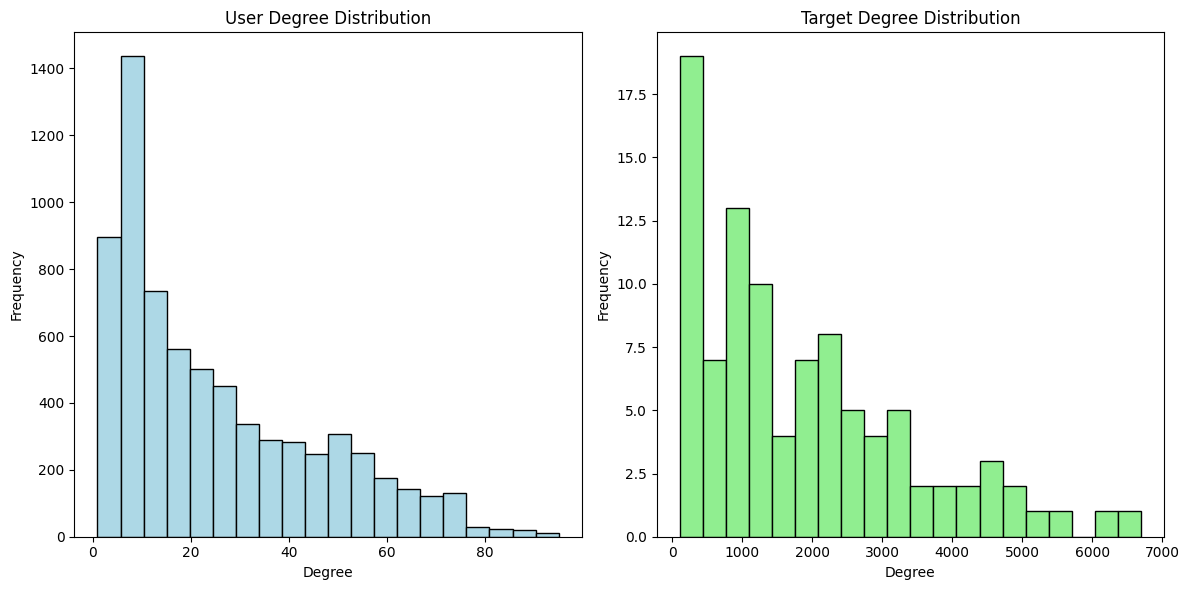

In [11]:
# 2. Plot Degree Distributions
plt.figure(figsize=(12, 6))

# User Degree Distribution
plt.subplot(1, 2, 1)
plt.hist(user_degrees.values(), bins=20, color='lightblue', edgecolor='black')
plt.title('User Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')

# Target Degree Distribution
plt.subplot(1, 2, 2)
plt.hist(target_degrees.values(), bins=20, color='lightgreen', edgecolor='black')
plt.title('Target Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Calculating best minimal value for power law fit
Power-law vs Exponential: R=1.32, p=0.1855, alpha=15.18, sigma=1.02


/usr/local/lib/python3.11/dist-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Power-law vs Lognormal: R=-3.00, p=0.0027


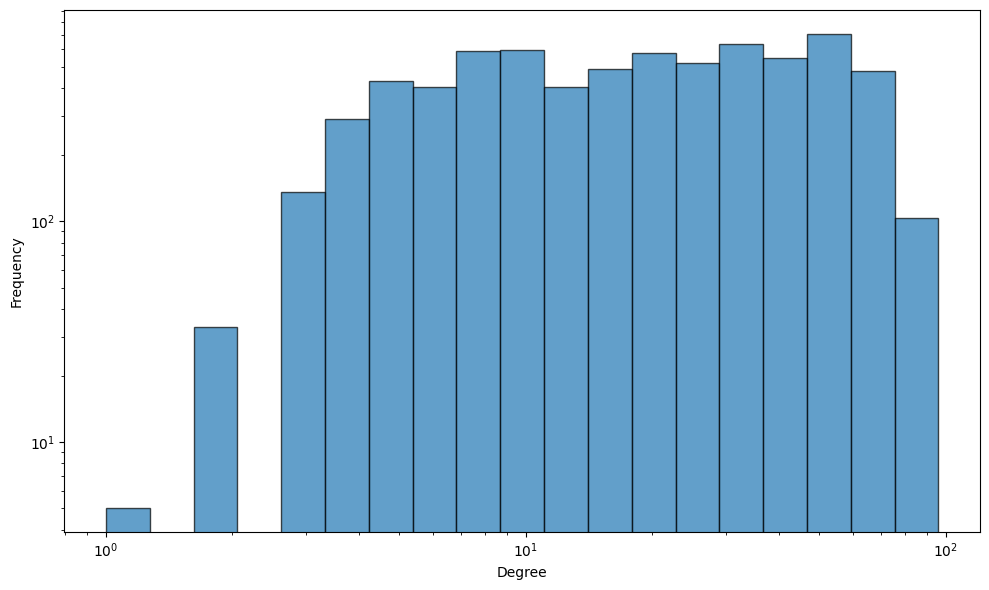

In [12]:
# User degree Power Law distribution
fit = powerlaw.Fit([d for n, d in B.degree(user_nodes)])
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
alpha, sigma = fit.alpha, fit.sigma
print(f"Power-law vs Exponential: R={R:.2f}, p={p:.4f}, alpha={alpha:.2f}, sigma={sigma:.2f}")

R, p = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
print(f"Power-law vs Lognormal: R={R:.2f}, p={p:.4f}")

# Plot degree distribution for each phase
fig, ax = plt.subplots(figsize=(10, 6))

degrees = [d for n, d in B.degree(user_nodes)]
ax.hist(degrees, bins=np.logspace(0, np.log10(max(degrees) + 1), 20), edgecolor='black', alpha=0.7)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Degree")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Calculating best minimal value for power law fit
Power-law vs Exponential: R=-2.91, p=0.0036, alpha=2.86, sigma=0.28
Power-law vs Lognormal: R=-2.00, p=0.0459


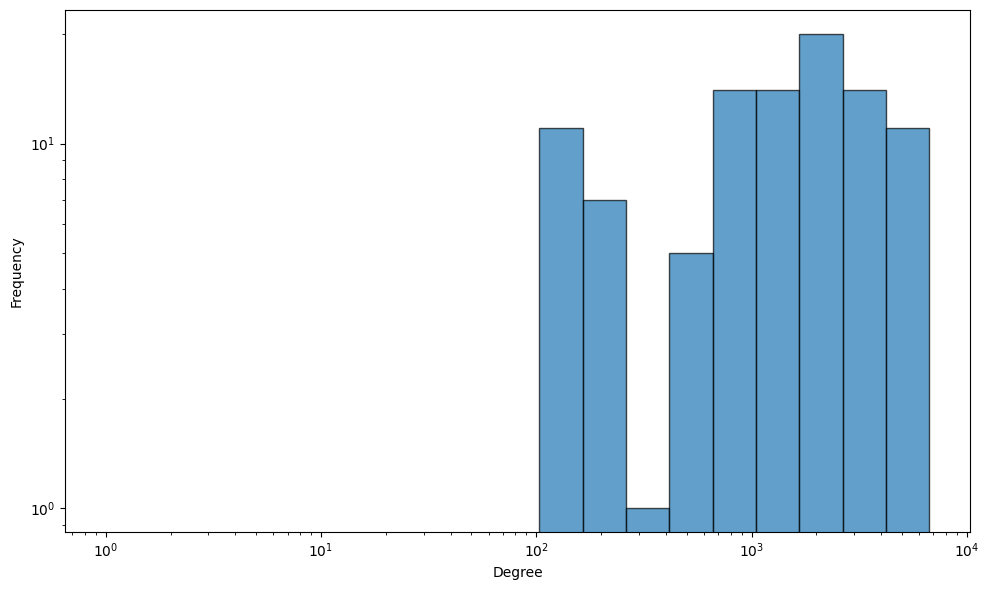

In [13]:
# User degree Power Law distribution
fit = powerlaw.Fit([d for n, d in B.degree(target_nodes)])
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
alpha, sigma = fit.alpha, fit.sigma
print(f"Power-law vs Exponential: R={R:.2f}, p={p:.4f}, alpha={alpha:.2f}, sigma={sigma:.2f}")

R, p = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
print(f"Power-law vs Lognormal: R={R:.2f}, p={p:.4f}")

# Plot degree distribution for each phase
fig, ax = plt.subplots(figsize=(10, 6))

degrees = [d for n, d in B.degree(target_nodes)]
ax.hist(degrees, bins=np.logspace(0, np.log10(max(degrees) + 1), 20), edgecolor='black', alpha=0.7)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Degree")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [14]:
# --- Network Density ---
overall_density = nx.density(B)  # Density of the entire bipartite network
print(f"Overall Network Density: {overall_density:.4f}")


# --- Subgraphs for Dropout and Non-Dropout Users ---
dropout_users = df_actions_labels[df_actions_labels['LABEL'] == 1]['USERID'].unique().tolist()
non_dropout_users = df_actions_labels[df_actions_labels['LABEL'] == 0]['USERID'].unique().tolist()

# Create subgraphs
dropout_subgraph = B.subgraph(dropout_users + target_nodes)
non_dropout_subgraph = B.subgraph(non_dropout_users + target_nodes)

dropout_density = nx.density(dropout_subgraph)
non_dropout_density = nx.density(non_dropout_subgraph)


print(f"Dropout User Subgraph Density: {dropout_density:.4f}")
print(f"Non-Dropout User Subgraph Density: {non_dropout_density:.4f}")

# --- Comparison ---
print("\n--- Comparison ---")
if dropout_density < non_dropout_density:
    print("Dropout users appear to be less connected (lower subgraph density).")
else:
    print("Dropout users do not appear to be less connected (higher or equal subgraph density).")

Overall Network Density: 0.0072
Dropout User Subgraph Density: 0.0075
Non-Dropout User Subgraph Density: 0.0072

--- Comparison ---
Dropout users do not appear to be less connected (higher or equal subgraph density).


In [15]:
# 3. Compare Average Degree for Dropouts vs. Non-dropouts

# Get dropout and non-dropout edges
dropout_edges = [(u, v) for u, v, data in subgraph.edges(data=True) if data.get('dropout', 0) == 1]
non_dropout_edges = [(u, v) for u, v, data in subgraph.edges(data=True) if data.get('dropout', 0) == 0]

# Calculate average degrees
avg_degree_dropout_users = np.mean([subgraph.degree(u) for u, _ in dropout_edges if u in user_nodes])
avg_degree_non_dropout_users = np.mean([subgraph.degree(u) for u, _ in non_dropout_edges if u in user_nodes])

print(f"Average Degree of Dropout Users: {avg_degree_dropout_users:.2f}")
print(f"Average Degree of Non-Dropout Users: {avg_degree_non_dropout_users:.2f}")


Average Degree of Dropout Users: 11.50
Average Degree of Non-Dropout Users: 50.48


Instead of relying on degree-distribution, I will use degree centrality, how many times students interacted with them, to rank the importance of 97 activities. Activities with high degree centrality indicate either high student interaction or multiple attempts before completion.

In [16]:
# --- Centrality Measures ---

degree_centrality = nx.degree_centrality(B)

# Filter for activities (bipartite set 1) and sort by degree centrality
activity_degree_centrality = {node: centrality for node, centrality in degree_centrality.items() if B.nodes[node]['bipartite'] == 1}
sorted_activity_degree = sorted(activity_degree_centrality.items(), key=lambda item: item[1], reverse=True)

print("Top 10 Activities by Degree Centrality:")
for activity, centrality in sorted_activity_degree[:10]:
    print(f"Activity: {activity}, Degree Centrality: {centrality:.4f}")

Top 10 Activities by Degree Centrality:
Activity: 1, Degree Centrality: 0.9503
Activity: 3, Degree Centrality: 0.8744
Activity: 4, Degree Centrality: 0.7922
Activity: 7, Degree Centrality: 0.7407
Activity: 8, Degree Centrality: 0.7119
Activity: 5, Degree Centrality: 0.7039
Activity: 9, Degree Centrality: 0.6543
Activity: 14, Degree Centrality: 0.6482
Activity: 13, Degree Centrality: 0.6245
Activity: 6, Degree Centrality: 0.6083


### Bottleneck Activitiees
To understand which activities contribute most to dropout behavior, I analyzed the top activities by dropout rate and the last actions performed before disengagement.


    TARGETID  DropoutRate
16        16     0.045276
95        95     0.042857
13        13     0.040000
15        15     0.038210
89        89     0.028369
11        11     0.022078
91        91     0.021739
27        27     0.021261
24        24     0.021002
19        19     0.020370


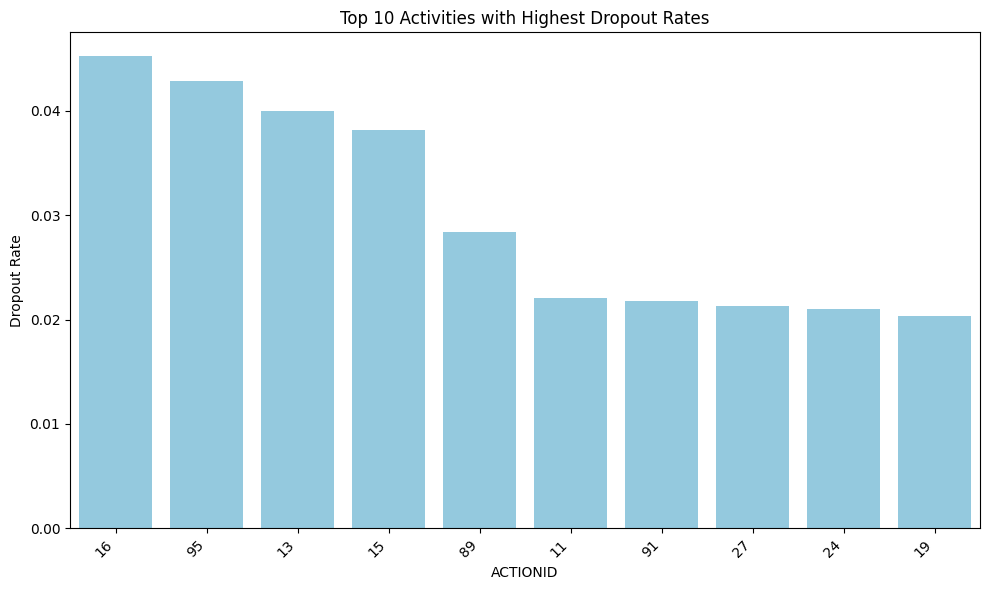

In [17]:
# --- Dropout Pattern Analysis ---

# Activity Dropout Rate

# 1. Calculate dropout rates per activity
activity_dropout_rates = df_actions_labels.groupby('TARGETID')['LABEL'].mean().reset_index()
activity_dropout_rates.columns = ['TARGETID', 'DropoutRate']

# 2. Rank activities with highest dropout rates
top_dropout_activities = activity_dropout_rates.sort_values(by='DropoutRate', ascending=False).head(10)
print(top_dropout_activities)
# 3. Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x='TARGETID', y='DropoutRate', data=top_dropout_activities, color='skyblue', order=top_dropout_activities['TARGETID']) # Order bars by TARGETID
plt.title('Top 10 Activities with Highest Dropout Rates')
plt.xlabel('ACTIONID')
plt.ylabel('Dropout Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Out of 4,066 dropout record actions, the most common last interactions before dropout involved activities 13, 16, 15, 8, and 9. Notably, activities 13 had high degree centrality, making it a critical point of engagement.


To assess whether these activities are genuinely discouraging, I examined the number of attempts before dropout compared to non-dropout students.


In [18]:
# User Behavior Before Dropout

dropout_users = df_actions_labels[df_actions_labels['LABEL'] == 1]['USERID'].unique()
non_dropout_users = df_actions_labels[df_actions_labels['LABEL'] == 0]['USERID'].unique()

# Calculate average number of actions
avg_actions_dropout = df_actions_labels[df_actions_labels['USERID'].isin(dropout_users)].groupby('USERID').size().mean()
avg_actions_non_dropout = df_actions_labels[df_actions_labels['USERID'].isin(non_dropout_users)].groupby('USERID').size().mean()

print(f"Average Actions Before Dropout: {avg_actions_dropout:.2f}")
print(f"Average Actions for Non-Dropouts: {avg_actions_non_dropout:.2f}")

Average Actions Before Dropout: 31.73
Average Actions for Non-Dropouts: 60.57


In [20]:
# --- Common Last Actions Before Dropout Analysis ---

# Get common last actions before dropout
last_actions_dropout = df_actions_labels[df_actions_labels['LABEL'] == 1].groupby('USERID')['TARGETID'].last().value_counts().head(10)
# Get interactions with last activity before dropout
last_action_interactions = {}
for user_id, last_action in df_actions_labels[df_actions_labels['LABEL'] == 1].groupby('USERID')['TARGETID'].last().items():
    # Count interactions for this user with their last action
    interactions_count = df_actions_labels[(df_actions_labels['USERID'] == user_id) & (df_actions_labels['TARGETID'] == last_action)].shape[0]
    last_action_interactions[user_id] = interactions_count

# Calculate average actions before next node for non-dropouts

# Group by USERID and TIMEID to get sequences of actions for each user
user_action_sequences = df_actions_labels.sort_values(by=['USERID', 'TIMESTAMP']).groupby('USERID')['TARGETID'].apply(list)

def avg_actions_before_next(sequences, dropout_status):
    total_actions = 0
    total_transitions = 0

    # Iterate through sequences and check dropout status using sequences.index
    for user_id, seq in sequences.items():
        user_label = df_actions_labels[df_actions_labels['USERID'] == user_id]['LABEL'].iloc[0]  # Get user's dropout status
        if user_label == dropout_status:  # If user matches the desired dropout status
            total_transitions += len(seq) - 1  # Number of transitions between nodes
            total_actions += len(seq)

    if total_transitions == 0:
        return 0  # Handle cases with no transitions
    else:
        return total_actions / total_transitions

avg_actions_non_dropout = avg_actions_before_next(user_action_sequences, 0)

print(f"Average Actions Before Next Node (Non-Dropouts): {avg_actions_non_dropout:.2f}")

# Calculate the average number of interactions with the last activity for dropouts
average_interactions = np.mean(list(last_action_interactions.values()))
print(f"\nAverage number of interactions with the last activity before dropout: {average_interactions:.2f}")

# Analyze interactions with all last actions in last_actions_dropout
average_interactions_for_last_actions = {}

for target_id in last_actions_dropout.index:  # Iterate through each TARGETID

    # Get users who dropped out and whose last action was the current target_id
    dropout_users_with_target = df_actions_labels[
        (df_actions_labels['LABEL'] == 1) & (df_actions_labels.groupby('USERID')['TARGETID'].transform('last') == target_id)
    ]['USERID'].unique()

    # Calculate average interactions with target_id for these users
    interaction_counts = []
    for user_id in dropout_users_with_target:
        count = df_actions_labels[(df_actions_labels['USERID'] == user_id) & (df_actions_labels['TARGETID'] == target_id)].shape[0]
        interaction_counts.append(count)

    average_interactions = np.mean(interaction_counts)
    average_interactions_for_last_actions[target_id] = average_interactions

# Print the results
print("\nAverage Interactions with Last Actions Before Dropout:")
for target_id, avg_interactions in average_interactions_for_last_actions.items():
    print(f"TARGETID {target_id}: {avg_interactions:.2f} average interactions")

# --- Common Last Actions Before Dropout Analysis ---

# Calculate average actions before next node for non-dropouts

# Group by USERID and TIMEID to get sequences of actions for each user
user_action_sequences = df_actions_labels.sort_values(by=['USERID', 'TIMESTAMP']).groupby('USERID')['TARGETID'].apply(list)

def avg_actions_before_next(sequences, dropout_status):
    total_actions = 0
    total_transitions = 0

    # Iterate through sequences and check dropout status using sequences.index
    for user_id, seq in sequences.items():
        user_label = df_actions_labels[df_actions_labels['USERID'] == user_id]['LABEL'].iloc[0]  # Get user's dropout status
        if user_label == dropout_status:  # If user matches the desired dropout status
            total_transitions += len(seq) - 1  # Number of transitions between nodes
            total_actions += len(seq)

    if total_transitions == 0:
        return 0  # Handle cases with no transitions
    else:
        return total_actions / total_transitions

avg_actions_non_dropout = avg_actions_before_next(user_action_sequences, 0)

print(f"Average Actions Before Next Node (Non-Dropouts): {avg_actions_non_dropout:.2f}")

Average Actions Before Next Node (Non-Dropouts): 1.02

Average number of interactions with the last activity before dropout: 2.19

Average Interactions with Last Actions Before Dropout:
TARGETID 13: 1.68 average interactions
TARGETID 16: 1.69 average interactions
TARGETID 15: 1.42 average interactions
TARGETID 8: 3.03 average interactions
TARGETID 9: 2.75 average interactions
TARGETID 3: 3.62 average interactions
TARGETID 7: 2.75 average interactions
TARGETID 27: 1.69 average interactions
TARGETID 5: 3.08 average interactions
TARGETID 19: 1.38 average interactions
Average Actions Before Next Node (Non-Dropouts): 1.02


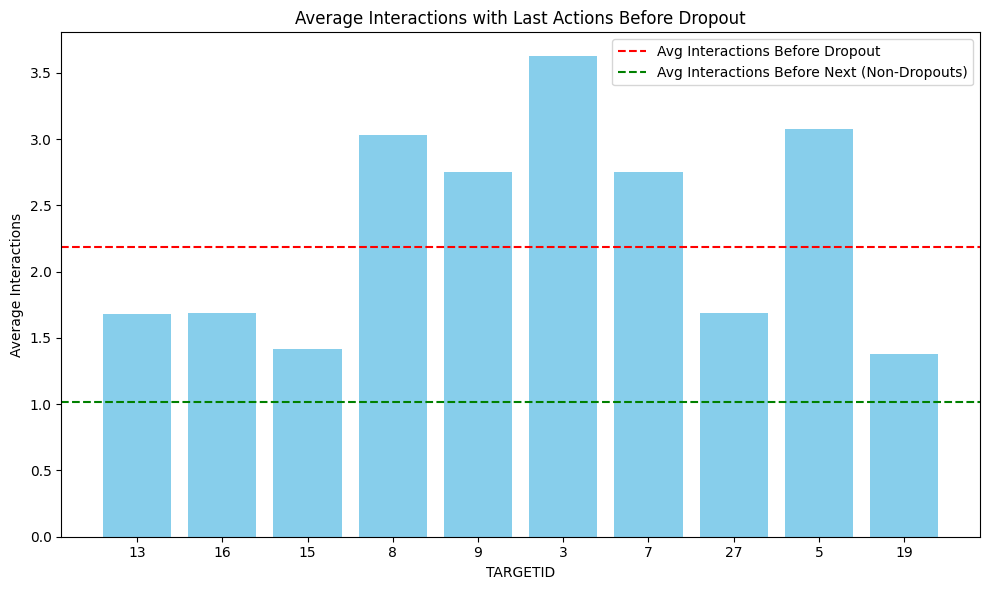

In [21]:
# --- Common Last Actions Before Dropout Analysis ---

# Analyze interactions with all last actions in last_actions_dropout
average_interactions_for_last_actions = {}

for target_id in last_actions_dropout.index:  # Iterate through each TARGETID

    # Get users who dropped out and whose last action was the current target_id
    dropout_users_with_target = df_actions_labels[
        (df_actions_labels['LABEL'] == 1) & (df_actions_labels.groupby('USERID')['TARGETID'].transform('last') == target_id)
    ]['USERID'].unique()

    # Calculate average interactions with target_id for these users
    interaction_counts = []
    for user_id in dropout_users_with_target:
        count = df_actions_labels[(df_actions_labels['USERID'] == user_id) & (df_actions_labels['TARGETID'] == target_id)].shape[0]
        interaction_counts.append(count)

    average_interactions = np.mean(interaction_counts)
    average_interactions_for_last_actions[target_id] = average_interactions

# Create DataFrame for plotting
data = pd.DataFrame(list(average_interactions_for_last_actions.items()), columns=['TARGETID', 'Average Interactions'])

# --- Calculate average number of interactions with the last activity before dropout ---
# 1. Get common last actions before dropout
last_actions_dropout = df_actions_labels[df_actions_labels['LABEL'] == 1].groupby('USERID')['TARGETID'].last().value_counts().head(10)
# 2. Get interactions with last activity before dropout
last_action_interactions = {}
for user_id, last_action in df_actions_labels[df_actions_labels['LABEL'] == 1].groupby('USERID')['TARGETID'].last().items():
    # Count interactions for this user with their last action
    interactions_count = df_actions_labels[(df_actions_labels['USERID'] == user_id) & (df_actions_labels['TARGETID'] == last_action)].shape[0]
    last_action_interactions[user_id] = interactions_count

# 3. Calculate the average number of interactions with the last activity
avg_interactions_before_dropout = np.mean(list(last_action_interactions.values()))

# --- Calculate Average Actions Before Next Node for Non-dropouts ---
# Group by USERID and TIMEID to get sequences of actions for each user
user_action_sequences = df_actions_labels.sort_values(by=['USERID', 'TIMESTAMP']).groupby('USERID')['TARGETID'].apply(list)

def avg_actions_before_next(sequences, dropout_status):
    total_actions = 0
    total_transitions = 0

    # Iterate through sequences and check dropout status using sequences.index
    for user_id, seq in sequences.items():
        user_label = df_actions_labels[df_actions_labels['USERID'] == user_id]['LABEL'].iloc[0]  # Get user's dropout status
        if user_label == dropout_status:  # If user matches the desired dropout status
            total_transitions += len(seq) - 1  # Number of transitions between nodes
            total_actions += len(seq)

    if total_transitions == 0:
        return 0  # Handle cases with no transitions
    else:
        return total_actions / total_transitions

avg_actions_non_dropouts = avg_actions_before_next(user_action_sequences, 0)

# --- Create the bar chart ---
fig, ax = plt.subplots(figsize=(10, 6))

# Treat TARGETID as labels (categorical data)
x_pos = np.arange(len(data['TARGETID']))  # Create positions for the bars
ax.bar(x_pos, data['Average Interactions'], color='skyblue')

# Set x-axis labels
ax.set_xticks(x_pos)
ax.set_xticklabels(data['TARGETID'])

# Set title and labels
ax.set_title('Average Interactions with Last Actions Before Dropout')
ax.set_xlabel('TARGETID')
ax.set_ylabel('Average Interactions')

# Add benchmark lines
ax.axhline(y=avg_interactions_before_dropout, color='red', linestyle='--', label='Avg Interactions Before Dropout')
ax.axhline(y=avg_actions_non_dropouts, color='green', linestyle='--', label='Avg Interactions Before Next (Non-Dropouts)')

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


Non-Dropout Students seem to have an easy transition to the next activity (1.02 attempts on average) and Dropout Students dropouts after an average of 2.19 attempts.

For students that churned at Activity 13, they had slightly higher attempts (1.68) than the non-dropout benchmark. This result suggests that activity 13 high degree centrality is mostly attributed to its high number of students interacting. Hence, it is crucial in the learning journey for students; however, with high dropout rate, this activity is also discouraging for students to move on to the next activity.


## Discussion
The analysis revealed that students struggling with specific activities are significantly more likely to drop out, particularly if they fail within their first few attempts. Surprisingly, network connectivity alone does not serve as a strong predictor of dropout behavior. Instead, dropout patterns are more closely tied to engagement with particular activities, suggesting that course design and individual activity structure play a more critical role than mere connectivity.

To address these challenges, I propose several interventions. Implementing adaptive feedback mechanisms, such as real-time hints and scaffolding strategies, could help students navigate difficult activities and improve completion rates. Additionally, an early warning system could identify at-risk students based on repeated failed attempts, allowing for timely and personalized support. Encouraging peer-assisted learning through discussion forums and community engagement may also enhance student persistence, particularly in challenging course modules.
Despite these insights, our study has some limitations. The dataset does not account for external factors such as student motivation, prior knowledge, or course difficulty, all of which may influence engagement levels. Furthermore, while we focused on interaction patterns within the MOOC platform, we did not assess the quality of instructional materials or teaching methods. Future research could integrate qualitative data to provide a more holistic understanding of student dropout behavior and refine intervention strategies accordingly.


## Conclusion
This study highlights key activities that contribute to student dropout in MOOCs. By applying network analysis, I identified activities where students disengage and proposed targeted interventions to improve retention. The findings suggest that early interventions in difficult activities and adaptive feedback mechanisms could significantly enhance student engagement and reduce dropout rates.


## Citation
Kumar, S., Zhang, X., & Leskovec, J. (2019). Predicting dynamic embedding trajectory in temporal interaction networks. Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, 1269-1278. ACM.